# Acknowledgements
https://www.kaggle.com/code/khoongweihao/covid-19-ct-scan-xray-cnn-detector/data

- Dataset from https://github.com/ieee8023/covid-chestxray-dataset
- COVID-19 Detector code from https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/

# Imports

In [1]:
import pandas as pd
import os

In [2]:
# General libraries
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

# Deep learning libraries
#import keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

#Util Component 1: Confusion matrix report/Accuracy measures
from sklearn.metrics import accuracy_score, confusion_matrix

# disabling warnings
import logging
logging.getLogger('tensorflow').disabled = True #Jordan_note: Disable red warning lines seen at model architecture creation.

# Utility Functions

In [3]:
def renderConfusionMetrics ( ___model, _testData, _testLabels, enableTraining, ___train_gen, ___test_gen, __batch_size, __epochs, hdf5_testSaveFileName ):
    preds = ___model.predict(_testData)

    acc = accuracy_score(_testLabels, np.round(preds))*100
    cm = confusion_matrix(_testLabels, np.round(preds))
    tn, fp, fn, tp = cm.ravel()


    print('\nCONFUSION MATRIX FORMAT ------------------\n')
    print("[true positives    false positives]")
    print("[false negatives    true negatives]\n\n")

    print('CONFUSION MATRIX ------------------')
    print(cm)

    print('\nTEST METRICS ----------------------')
    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    specificity = tn/(tn+fp)*100 #Jordan_note: added specificity calculation 
    print('Accuracy: {}%'.format(acc))
    print('Precision: {}%'.format(precision))
    print('Recall/Sensitivity: {}%'.format(recall)) #Jordan_note: added sensitivity label
    print('Specificity {}%'.format(specificity)) #Jordan_note: added specificity calculation 
    print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


    if enableTraining:
        checkpoint = ModelCheckpoint(filepath=hdf5_testSaveFileName, save_best_only=True, save_weights_only=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


        hist = ___model.fit_generator(
                   ___train_gen, steps_per_epoch=___test_gen.samples // __batch_size, 
                   epochs=10, validation_data=___test_gen, 
                   validation_steps=___test_gen.samples // __batch_size, callbacks=[checkpoint, lr_reduce])

        print('\nTRAIN METRIC ----------------------')
        print('Covid19 Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.savefig('train_val_acc_loss.png')

In [4]:
#Util Component 2:model architecture description
def defineModelArchitecture (_img_dims ):
    # Input layer
    inputs = Input(shape=(_img_dims, _img_dims, 3))

    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    return inputs, output


###########
#Util Component 3: Data processor
#Note: This process does not use validation path, because validation path in the original competion reasonably had too little data (8 samples) to create any insight.
# the "directoryProcessArray" param from "reportFileDistributions" function corresponds to the hard-coded sub-directories of train and test, excluding val.
def process_data(___inputPath, img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=___inputPath+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=___inputPath+'reconstructed_test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(___inputPath + 'reconstructed_test' + cond)):
            img = cv2.imread(___inputPath+'reconstructed_test'+cond+img,0) #Replace plt.imread, with  gray scale cv2.imread(path,0), so that ui's image load process doesn't throw a pyimage10 error
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels
    

In [5]:
# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# Hyperparameters
img_dims = 150
batch_size = 32

In [7]:
inputs, output = defineModelArchitecture ( img_dims )

# Non-COVID-19 Lung Pneumonia Detection

In [8]:
# Creating model and compiling
model_pneumoniaDetector = Model(inputs=inputs, outputs=output)
model_pneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_pneumoniaDetector.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128   

In [9]:
#https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
input_path_b = "C:\\Users\\charl\\Documents\\College\\Spring 2022\\Thesis\\Data\\Chest XRAY - Classified\\chest_xray\\"


In [10]:
# Getting the data
train_gen, test_gen, test_data_b, test_labels_b = process_data(input_path_b, img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 64 images belonging to 2 classes.



CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[32  0]
 [32  0]]

TEST METRICS ----------------------
Accuracy: 50.0%
Precision: nan%
Recall/Sensitivity: 0.0%
Specificity 100.0%
F1-score: nan


C:\Users\charl\AppData\Local\Temp\ipykernel_27972\3099396536.py:17: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp/(tp+fp)*100
C:\Users\charl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
2/2 [==============================] - 4s 727ms/step - loss: 0.6903 - accuracy: 0.7031 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 1s 880ms/step - loss: 0.6681 - accuracy: 0.7031 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 1s 903ms/step - loss: 0.5799 - accuracy: 0.7812 - val_loss: 0.7249 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 1s 919ms/step - loss: 0.7849 - accuracy: 0.6250 - val_loss: 0.7451 - val_accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 1s 843ms/step - loss: 0.6312 - accuracy: 0.7656 - val_loss: 0.7258 - val_accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 1s 720ms/step - loss: 0.6128 - accuracy: 0.7031 - val_loss: 0.7159 - val_accuracy: 0.5000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/10
2/2 [==============================] - 1s 695ms/step - loss: 0.6252 

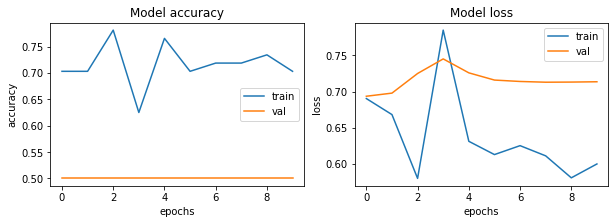

In [11]:
renderConfusionMetrics(model_pneumoniaDetector, test_data_b, test_labels_b, True, train_gen, test_gen, batch_size, 10, 'model_weights.hdf5')


# References

[1] Joseph Paul Cohen and Paul Morrison and Lan Dao. COVID-19 image data collection, arXiv, 2020. https://github.com/ieee8023/covid-chestxray-dataset

[2] https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/

## Thank you! I'll be updating this kernel from time to time, when new COVID-19 images come in. Stay safe and happy Kaggling everyone! :)